<h1 align="center">Introduction to SimpleElastix</h1>


## Contents
In this notebook we show how to  

- Install SimpleElastix
- Demonstrate the built-in registration methods

### Installation (Linux)




$ pip install SimpleElastix

or

In [ ]:
$ git clone https://github.com/kaspermarstal/SimpleElastix
$ mkdir build
$ cd build
$ cmake ../SimpleElastix/SuperBuild
$ make -j4

### Installation (Windows)

In [ ]:
$ git clone https://github.com/kaspermarstal/SimpleElastix
$ mkdir build
$ cd build
$ cmake ../SimpleElastix/SuperBuild
$ msbuild ALL_BUILD.vcxproj /p:configuration=release

Or follow the guides on https://simpleelastix.readthedocs.io/GettingStarted.html

<img src="WindowsInstallationConfigureCMake.png" style="width:400px"/>
<img src="WindowsInstallationBuildSolution.png" style="width:400px"/>

## Utility functions
A number of utility callback functions for image display and for plotting the similarity metric during registration.

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Callback invoked by the interact ipython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(14,10))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.figure(figsize=(11,9))
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Read images

We first read the images, casting the pixel type to that required for registration (Float32 or Float64) and look at them.

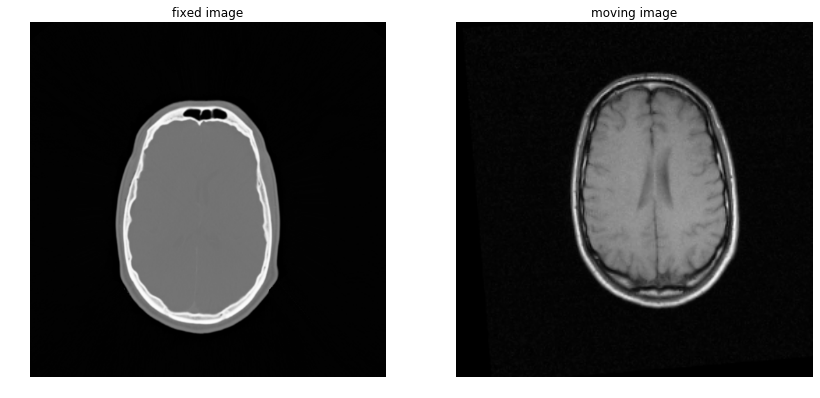

In [74]:
import SimpleITK as sitk
fixed_image =  sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32) 

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayFromImage(moving_image)));

## Registration 

Use the default registration procedure to register images. SimpleElastix uses multiple resolutions, Normalized Mutual Information and a self-tuning optimizer by defalt.

In [4]:
translation_result_image = sitk.Elastix(fixed_image, moving_image, 'translation')

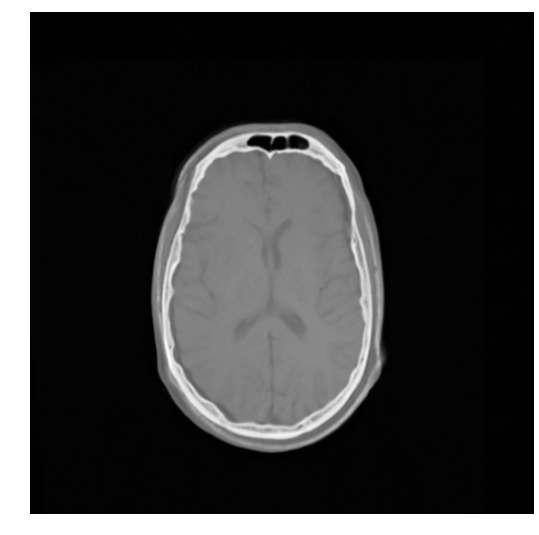

In [83]:
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(translation_result_image));

Nice, but still some rotation left.

In [6]:
affine_result_image = sitk.Elastix(fixed_image, moving_image, 'affine')

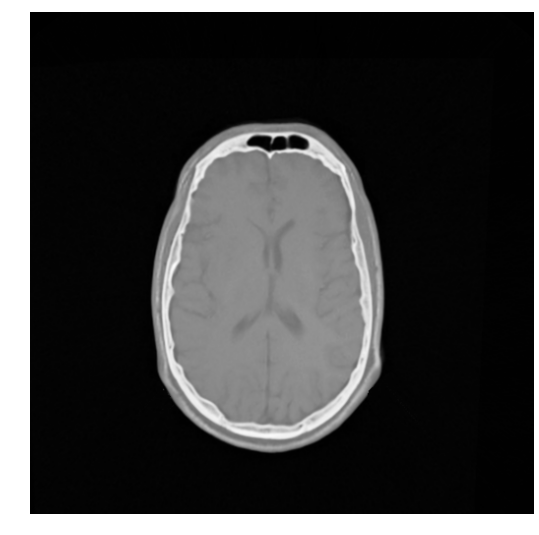

In [84]:
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(affine_result_image));

Better. Let's do a full the non-rigid registration.

In [8]:
bspline_result_image = sitk.Elastix(fixed_image, moving_image, 'bspline')

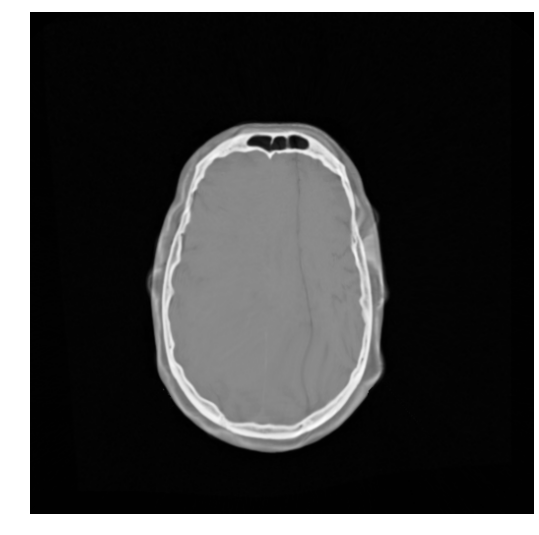

In [85]:
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(bspline_result_image));

Oops! The b-spline grid was to dense! Let's add some regularization.

In [10]:
bspline_parameter_map = sitk.GetDefaultParameterMap('bspline')
bspline_parameter_map["FinalGridSpacingInPhysicalUnits"] = ["30.0", "30.0"]
bspline_parameter_map["Metric"] = ["NormalizedMutualInformation", "TransformBendingEnergyPenalty"]
bspline_parameter_map["Metric1Weight"] = ["100"]

ElastixImageFilter = sitk.ElastixImageFilter()
ElastixImageFilter.SetParameterMap(bspline_parameter_map)
ElastixImageFilter.SetFixedImage(fixed_image)
ElastixImageFilter.SetMovingImage(moving_image)
custom_bspline_result_image = ElastixImageFilter.Execute()

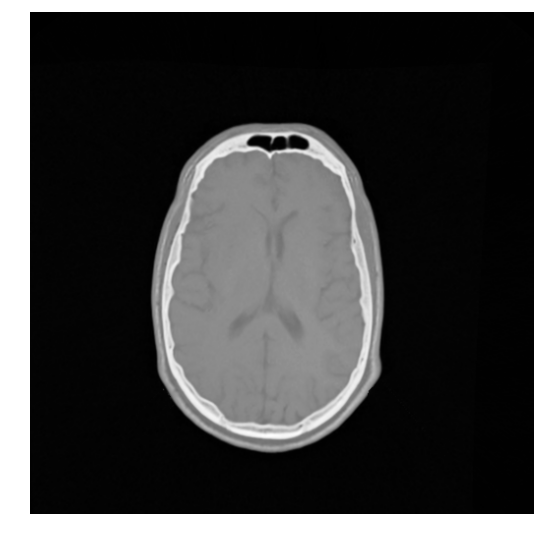

In [86]:
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(custom_bspline_result_image));

## Post registration analysis

In [32]:
import numpy 

zeros_array = numpy.zeros((26, 256, 256))
print(zeros_array.shape)
full_array = numpy.full((26, 256, 256), 455)

zeros_image = sitk.Cast(sitk.GetImageFromArray(zeros_array, isVector=False), moving_image.GetPixelID())
full_image = sitk.Cast(sitk.GetImageFromArray(full_array, isVector=False), moving_image.GetPixelID())

print(zeros_image.GetSize())
print(full_image.GetSize())

zeros_image.CopyInformation(moving_image)
full_image.CopyInformation(moving_image)

checkerboard_image = sitk.CheckerBoard(zeros_image, full_image, (8, 8, 8))
transformed_checkerboard_image = sitk.Transformix(checkerboard_image, ElastixImageFilter.GetTransformParameterMap())

(26, 256, 256)
(256, 256, 26)
(256, 256, 26)


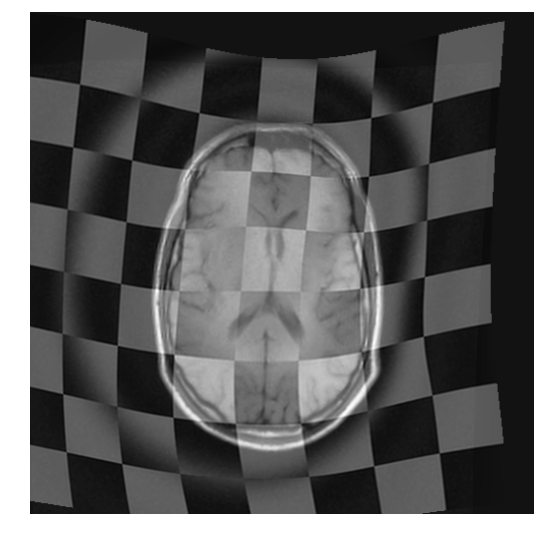

In [87]:
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(custom_bspline_result_image), moving=fixed(transformed_checkerboard_image));

Let's try with translation -> affine -> bspline

In [88]:
ElastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap('translation'))
ElastixImageFilter.AddParameterMap(sitk.GetDefaultParameterMap('affine'))
ElastixImageFilter.AddParameterMap(bspline_parameter_map)
custom_bspline_result_image = ElastixImageFilter.Execute()
transformed_checkerboard_image2 = sitk.Transformix(checkerboard_image, ElastixImageFilter.GetTransformParameterMap())

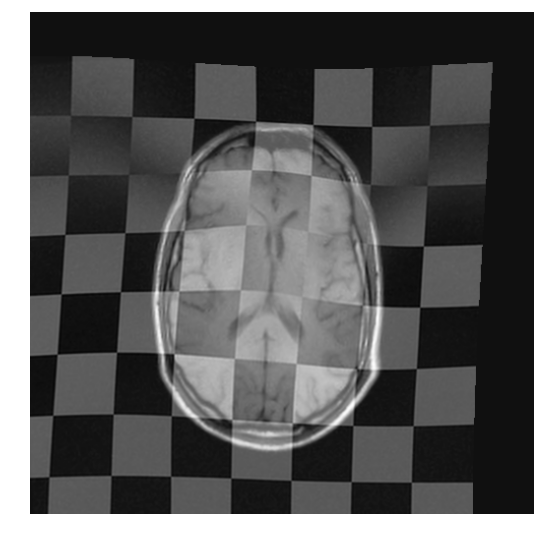

In [89]:
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(custom_bspline_result_image), moving=fixed(transformed_checkerboard_image2));